In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.ar_model import AutoReg

In [2]:
def ma_model(epsilon_prev, const, theta, sigma2):
    """ X_t = const + epsilon_t + theta * epsilon_{t-1} """

    epsilon_t = np.random.normal(loc=0, scale=np.sqrt(sigma2))
    next_logr = const + epsilon_t + theta * epsilon_prev

    return next_logr

# Round 1

In [3]:
price_0 = pd.read_csv('../data/raw/round_1/prices_round_1_day_-2.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_1/prices_round_1_day_-1.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_1/prices_round_1_day_0.csv', delimiter=';')

In [4]:
price_0 = price_0[price_0['product'] == 'SQUID_INK']
price_1 = price_1[price_1['product'] == 'SQUID_INK']
price_2 = price_2[price_2['product'] == 'SQUID_INK']

In [5]:
trades_0 = pd.read_csv('../data/raw/round_1/trades_round_1_day_-2.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_1/trades_round_1_day_-1.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_1/trades_round_1_day_0.csv', delimiter=';')

In [6]:
trades_0 = trades_0[trades_0['symbol'] == 'SQUID_INK']
trades_1 = trades_1[trades_1['symbol'] == 'SQUID_INK']
trades_2 = trades_2[trades_2['symbol'] == 'SQUID_INK']

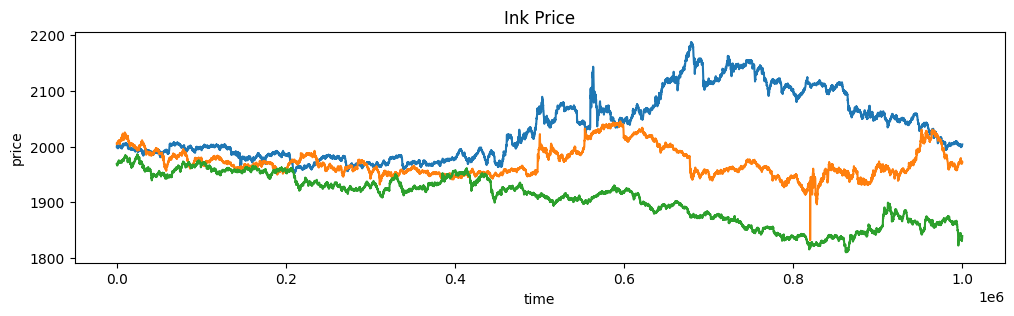

In [28]:
plt.figure(figsize=(12, 3))
plt.plot(price_0['timestamp'], price_0['mid_price'])
plt.plot(price_1['timestamp'], price_1['mid_price'])
plt.plot(price_2['timestamp'], price_2['mid_price'])
plt.title('Ink Price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

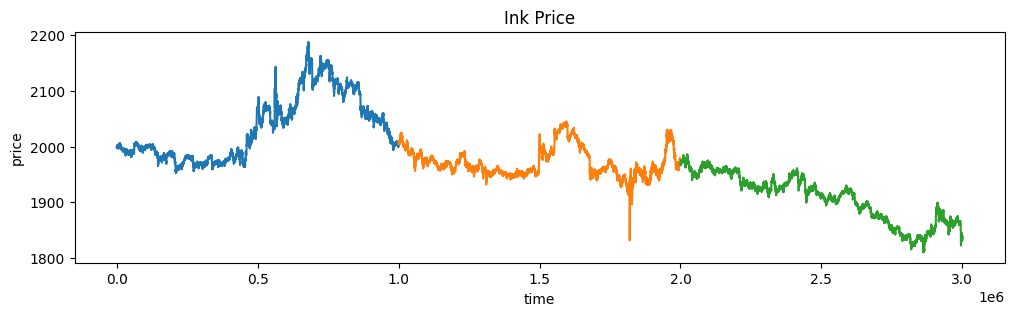

In [7]:
plt.figure(figsize=(12, 3))
plt.plot(price_0['timestamp'], price_0['mid_price'])
plt.plot(price_1['timestamp'] + 1000000, price_1['mid_price'])
plt.plot(price_2['timestamp'] + 2000000, price_2['mid_price'])
plt.title('Ink Price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [8]:
prices = pd.concat([price_0, price_1, price_2], axis=0).reset_index(drop=True)
trades = pd.concat([trades_0, trades_1, trades_2], axis=0).reset_index(drop=True)

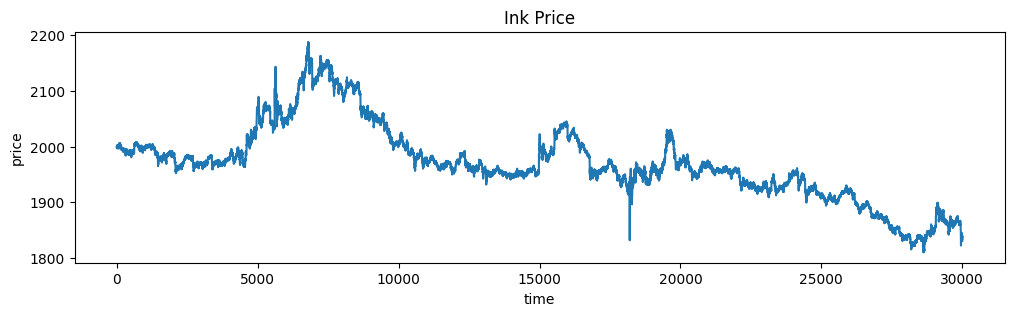

In [9]:
plt.figure(figsize=(12, 3))
plt.plot(prices['mid_price'])
plt.title('Ink Price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [10]:
bid_prices = prices[['bid_price_1', 'bid_price_2', 'bid_price_3']].to_numpy()
max_inds = prices[['bid_volume_1', 'bid_volume_2', 'bid_volume_3']].idxmax(axis=1).apply(lambda x: int(x[-1]) - 1).to_numpy()
pop_bid_prices = bid_prices[np.arange(len(bid_prices)), max_inds]

ask_prices = prices[['ask_price_1', 'ask_price_2', 'ask_price_3']].to_numpy()
max_inds = prices[['ask_volume_1', 'ask_volume_2', 'ask_volume_3']].idxmax(axis=1).apply(lambda x: int(x[-1]) - 1).to_numpy()
pop_ask_prices = ask_prices[np.arange(len(ask_prices)), max_inds]

prices = prices.assign(pop_bid_price=pop_bid_prices)
prices = prices.assign(pop_ask_price=pop_ask_prices)
prices = prices.assign(pop_mid_price=(pop_bid_prices + pop_ask_prices) / 2)

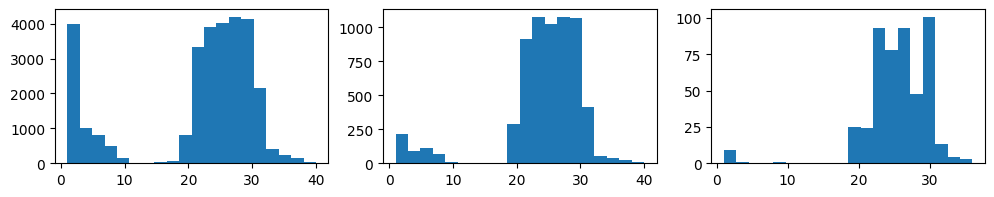

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))
ax[0].hist(prices['bid_volume_1'], bins=20)
ax[1].hist(prices['bid_volume_2'], bins=20)
ax[2].hist(prices['bid_volume_3'], bins=20)
plt.show()

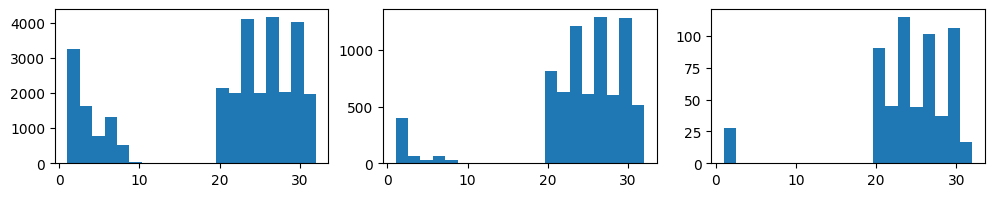

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))
ax[0].hist(prices['ask_volume_1'], bins=20)
ax[1].hist(prices['ask_volume_2'], bins=20)
ax[2].hist(prices['ask_volume_3'], bins=20)
plt.show()

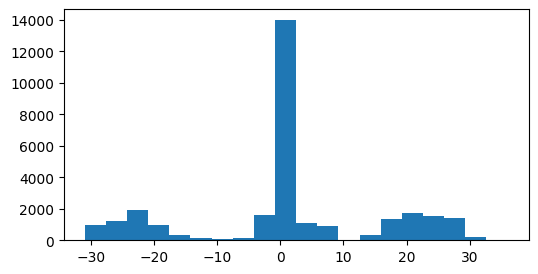

In [13]:
plt.figure(figsize=(6, 3))
plt.hist(prices['bid_volume_1'] - prices['ask_volume_1'], bins=20)
plt.show()

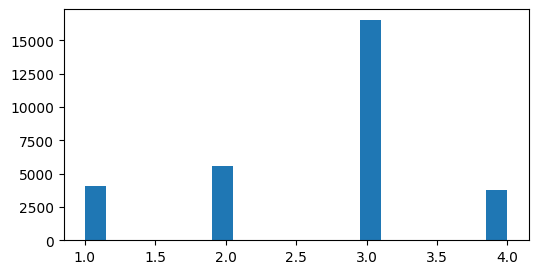

In [14]:
plt.figure(figsize=(6, 3))
plt.hist(prices['ask_price_1'] - prices['bid_price_1'], bins=20)
plt.show()

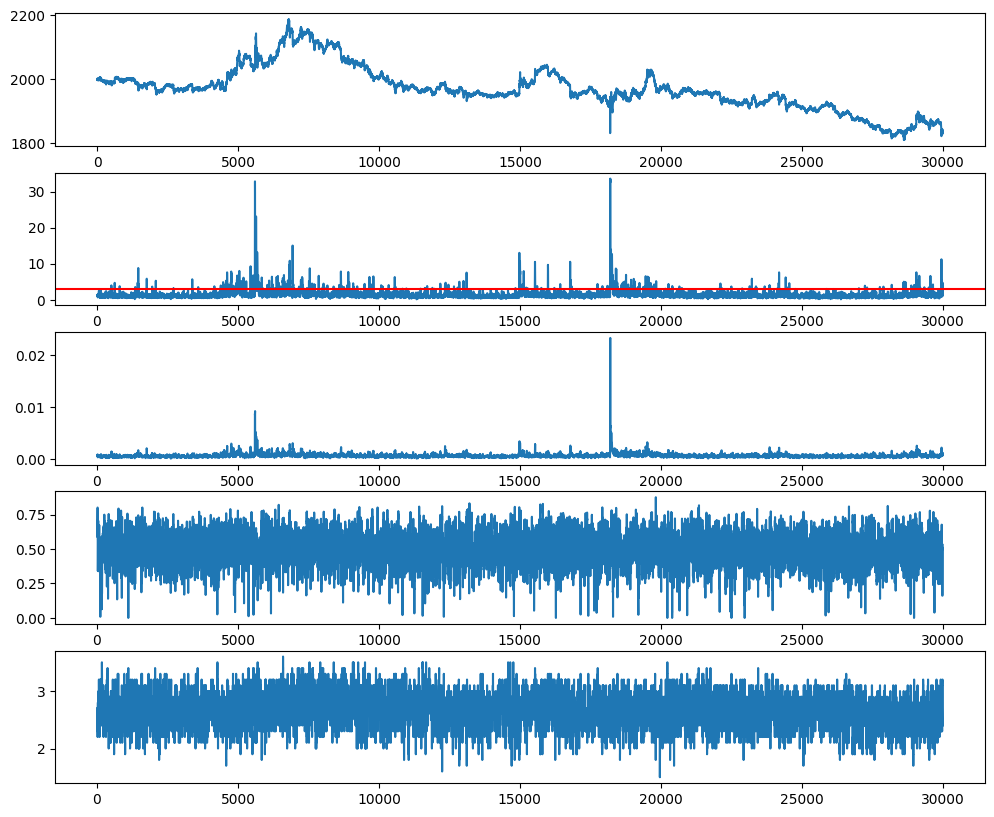

In [81]:
fig, ax = plt.subplots(5, 1, figsize=(12, 10))
ax[0].plot(prices['mid_price'])
ax[1].plot(prices['mid_price'].rolling(10).std())
ax[1].axhline(3, c='r')
ax[2].plot(np.log((prices['mid_price'] / prices['mid_price'].shift(1))).rolling(10).std())
ax[3].plot(((prices['bid_volume_1'] - prices['ask_volume_1']) / (prices['bid_volume_1'] + prices['ask_volume_1'])).rolling(10).std())
ax[4].plot((prices['ask_price_1'] - prices['bid_price_1']).rolling(10).mean())
plt.show()

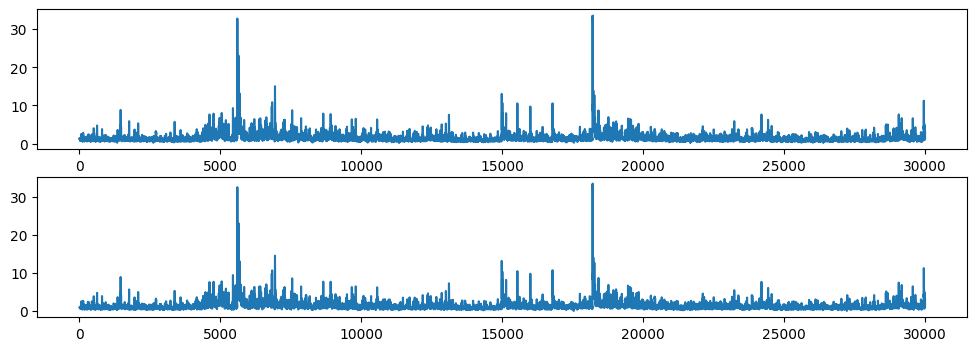

In [82]:
fig, ax = plt.subplots(2, 1, figsize=(12, 4))
ax[0].plot(prices['mid_price'].rolling(10).std())
ax[1].plot(prices['pop_mid_price'].rolling(10).std())
plt.show()

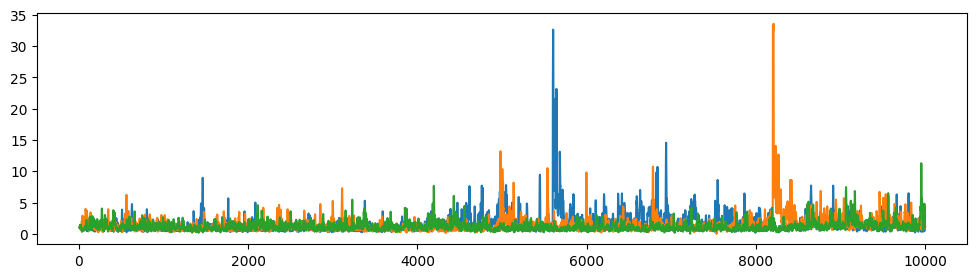

In [83]:
plt.figure(figsize=(12, 3))
plt.plot(prices['pop_mid_price'].iloc[:10000].rolling(10).std().to_numpy())
plt.plot(prices['pop_mid_price'].iloc[10000:20000].rolling(10).std().to_numpy())
plt.plot(prices['pop_mid_price'].iloc[20000:].rolling(10).std().to_numpy())
plt.show()

In [84]:
price = prices.iloc[1000:1100]

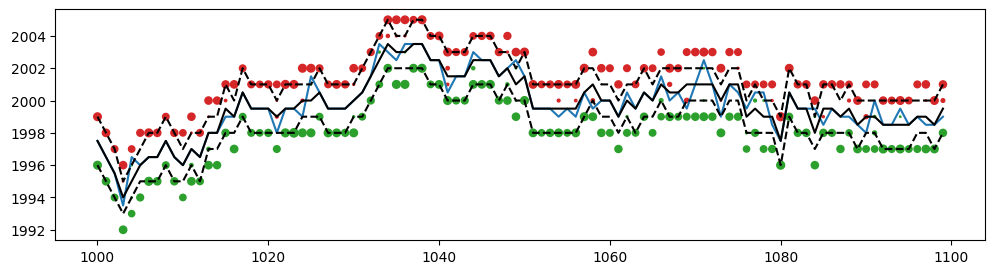

In [85]:
plt.figure(figsize=(12, 3))
plt.scatter(price['timestamp']//100, price['bid_price_1'], s=price['bid_volume_1'], c='tab:green')
plt.scatter(price['timestamp']//100, price['bid_price_2'], s=price['bid_volume_2'], c='tab:green')
plt.scatter(price['timestamp']//100, price['bid_price_3'], s=price['bid_volume_3'], c='tab:green')
plt.scatter(price['timestamp']//100, price['ask_price_1'], s=price['ask_volume_1'], c='tab:red')
plt.scatter(price['timestamp']//100, price['ask_price_2'], s=price['ask_volume_2'], c='tab:red')
plt.scatter(price['timestamp']//100, price['ask_price_3'], s=price['ask_volume_3'], c='tab:red')
plt.plot(price['timestamp']//100, price['mid_price'], c='tab:blue')
plt.plot(price['timestamp']//100, price['pop_mid_price'], c='k')
plt.plot(price['timestamp']//100, np.floor(price['pop_mid_price']) - 1, c='k', linestyle='dashed')
plt.plot(price['timestamp']//100, np.ceil(price['pop_mid_price']) + 1, c='k', linestyle='dashed')
plt.show()

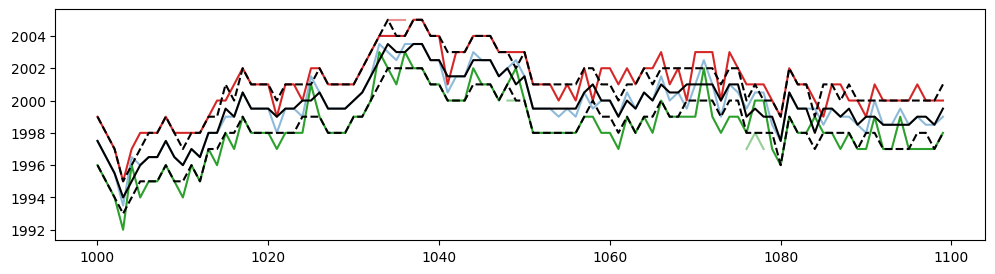

In [86]:
plt.figure(figsize=(12, 3))
plt.plot(price['timestamp']//100, price['bid_price_1'], c='tab:green')
plt.plot(price['timestamp']//100, price['bid_price_2'], c='tab:green', alpha=0.5)
plt.plot(price['timestamp']//100, price['bid_price_3'], c='tab:green', alpha=0.5)
plt.plot(price['timestamp']//100, price['ask_price_1'], c='tab:red')
plt.plot(price['timestamp']//100, price['ask_price_2'], c='tab:red', alpha=0.5)
plt.plot(price['timestamp']//100, price['ask_price_3'], c='tab:red', alpha=0.5)
plt.plot(price['timestamp']//100, price['mid_price'], c='tab:blue', alpha=0.5)
plt.plot(price['timestamp']//100, price['pop_mid_price'], c='k')
plt.plot(price['timestamp']//100, np.floor(price['pop_mid_price']) - 1, c='k', linestyle='dashed')
plt.plot(price['timestamp']//100, np.ceil(price['pop_mid_price']) + 1, c='k', linestyle='dashed')
plt.show()

## Price prediction - popular mid price

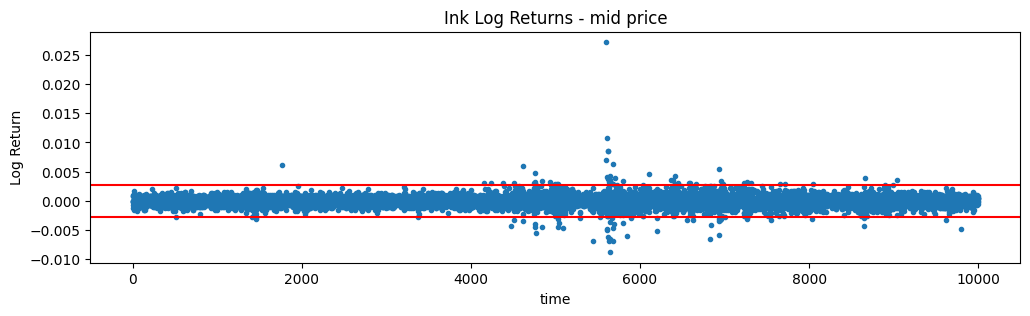

In [88]:
train = prices['mid_price'].iloc[:prices.shape[0] // 3].to_numpy()
valid = prices['mid_price'].iloc[prices.shape[0] // 3:prices.shape[0] // 3 * 2].to_numpy()
test = prices['mid_price'].iloc[prices.shape[0] // 3 * 2:].to_numpy()

train_logr = np.log(train[1:] / train[:-1])
valid_logr = np.log(valid[1:] / valid[:-1])
test_logr = np.log(test[1:] / test[:-1])

thr_h = train_logr.mean() + 3 * train_logr.std()
thr_l = train_logr.mean() - 3 * train_logr.std()

plt.figure(figsize=(12, 3))
plt.scatter(np.arange(len(train_logr)), train_logr, marker='.')
plt.axhline(thr_h, c='r')
plt.axhline(thr_l, c='r')
plt.title('Ink Log Returns - mid price')
plt.xlabel('time')
plt.ylabel('Log Return')
plt.show()

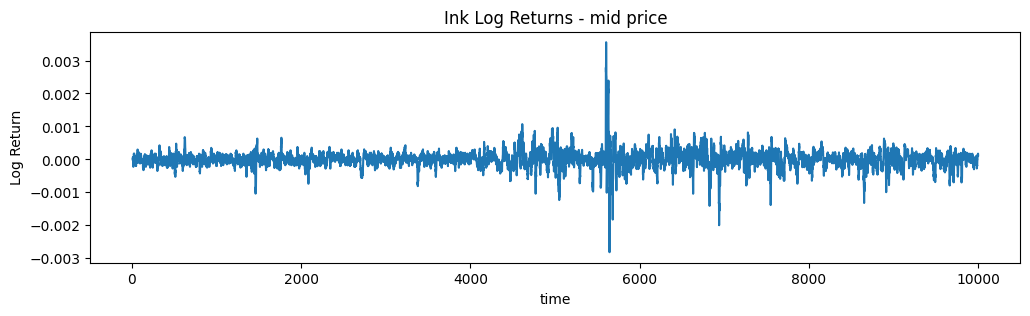

In [49]:
plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(train_logr)), pd.Series(train_logr).rolling(10).mean())
plt.title('Ink Log Returns - mid price')
plt.xlabel('time')
plt.ylabel('Log Return')
plt.show()

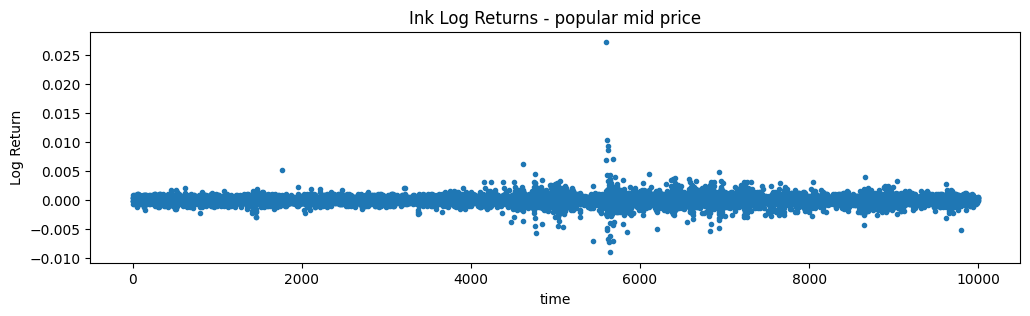

In [23]:
train = prices['pop_mid_price'].iloc[:prices.shape[0] // 3].to_numpy()
valid = prices['pop_mid_price'].iloc[prices.shape[0] // 3:prices.shape[0] // 3 * 2].to_numpy()
test = prices['pop_mid_price'].iloc[prices.shape[0] // 3 * 2:].to_numpy()

train_logr = np.log(train[1:] / train[:-1])
valid_logr = np.log(valid[1:] / valid[:-1])
test_logr = np.log(test[1:] / test[:-1])

plt.figure(figsize=(12, 3))
plt.scatter(np.arange(len(train_logr)), train_logr, marker='.')
plt.title('Ink Log Returns - popular mid price')
plt.xlabel('time')
plt.ylabel('Log Return')
plt.show()

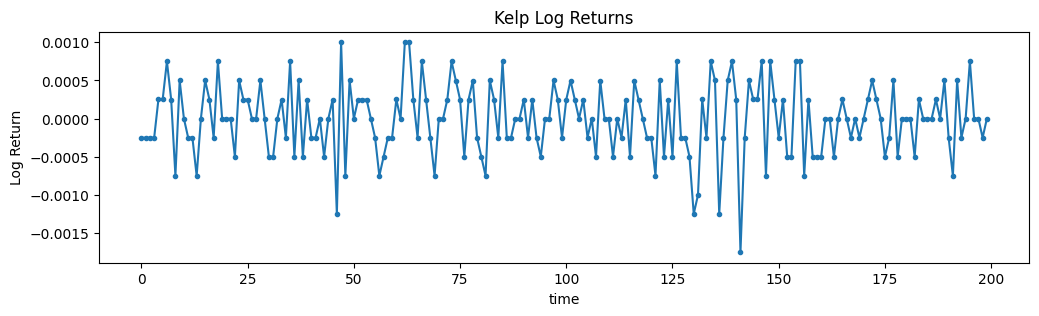

In [24]:
plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(train_logr[:200])), train_logr[:200], marker='.')
plt.title('Kelp Log Returns')
plt.xlabel('time')
plt.ylabel('Log Return')
plt.show()

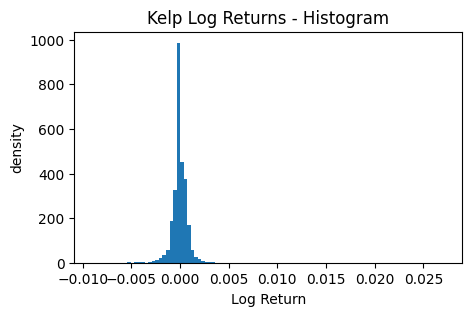

In [25]:
plt.figure(figsize=(5, 3))
plt.hist(train_logr, bins=100, density=True)
plt.title('Kelp Log Returns - Histogram')
plt.xlabel('Log Return')
plt.ylabel('density')
plt.show()

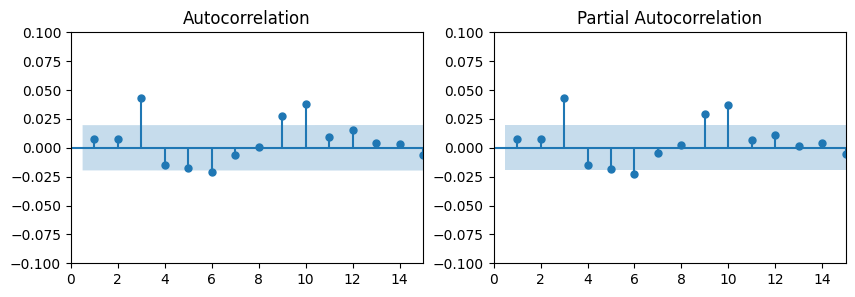

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(train_logr, ax=ax[0], zero=False)
plot_pacf(train_logr, ax=ax[1], zero=False)
ax[0].set_xlim([0, 15])
ax[1].set_xlim([0, 15])
ax[0].set_ylim([-.1, .1])
ax[1].set_ylim([-.1, .1])
plt.show()

In [27]:
# Perform Ljung-Box test for lags up to 10
result = acorr_ljungbox(train_logr, lags=[10], return_df=True)
print(result)

# Interpretation
if result['lb_pvalue'].values[0] > 0.05:
    print("Fail to reject null hypothesis: data may be white noise.")
else:
    print("Reject null hypothesis: data is not white noise.")

      lb_stat     lb_pvalue
10  51.799364  1.242965e-07
Reject null hypothesis: data is not white noise.


### Naive

In [100]:
rmse = np.mean(valid_logr ** 2) ** 0.5
print(f'Log-returns RMSE: {rmse}')

y = valid[1:]
y_pred = valid[:-1]
err = y - y_pred
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE: {rmse}')

Log-returns RMSE: 0.0010401324565068879
Price RMSE: 2.006371738426176


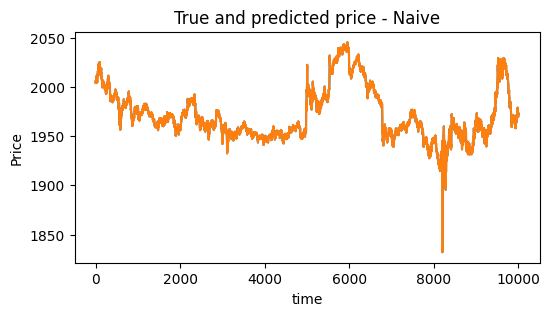

In [101]:
plt.figure(figsize=(6, 3))
plt.plot(y)
plt.plot(y_pred)
plt.title('True and predicted price - Naive')
plt.xlabel('time')
plt.ylabel('Price')
plt.show()

### MA(1)

In [102]:
model = ARIMA(train_logr, order=(0, 0, 1))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 9999
Model:                 ARIMA(0, 0, 1)   Log Likelihood               56801.775
Date:                Tue, 08 Apr 2025   AIC                        -113597.550
Time:                        11:29:05   BIC                        -113575.920
Sample:                             0   HQIC                       -113590.228
                               - 9999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.432e-08   8.75e-06      0.008      0.993   -1.71e-05    1.72e-05
ma.L1          0.0072      0.005      1.526      0.127      -0.002       0.017
sigma2      6.811e-07   1.26e-09    540.295      0.0

In [103]:
result.params

array([7.43188951e-08, 7.23623582e-03, 6.81139153e-07])

In [104]:
errs = [valid_logr[0] - 0]
preds = [0]
for i in range(1, len(valid_logr)):
    pred = ma_model(epsilon_prev=errs[i-1], const=result.params[0], theta=result.params[1], sigma2=result.params[2])
    err = test_logr[i] - pred
    preds.append(pred)
    errs.append(err)

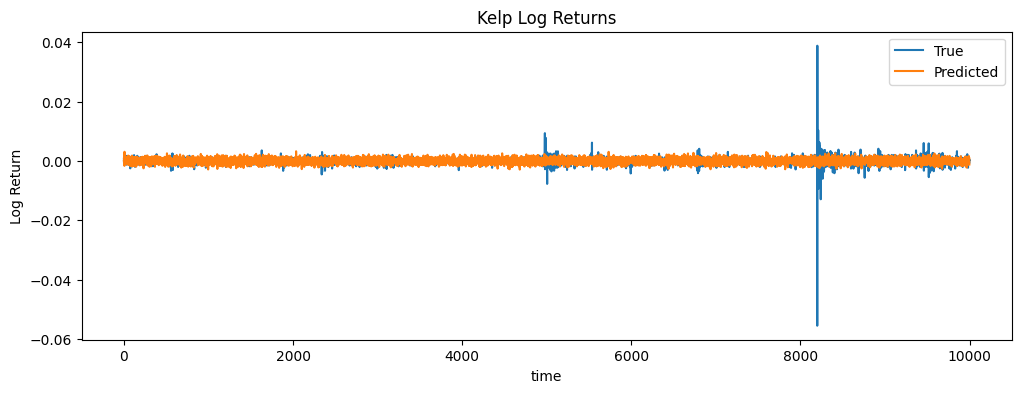

In [105]:
plt.figure(figsize=(12, 4))
plt.plot(valid_logr, label='True')
plt.plot(preds, label='Predicted')
plt.title('Kelp Log Returns')
plt.xlabel('time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

In [106]:
pred_price = valid[:-1] * np.exp(preds)

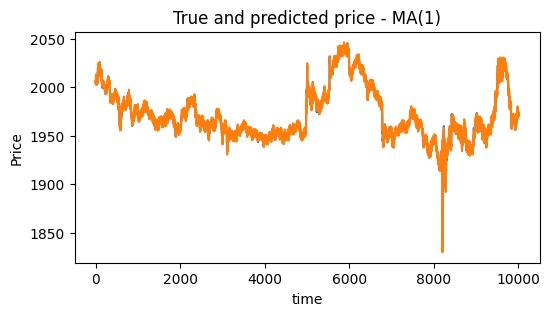

In [107]:
plt.figure(figsize=(6, 3))
plt.plot(valid[1:])
plt.plot(pred_price)
plt.title('True and predicted price - MA(1)')
plt.xlabel('time')
plt.ylabel('Price')
plt.show()

In [108]:
err = valid_logr - preds
rmse = np.mean(err ** 2) ** 0.5
print(f'Log-returns RMSE: {rmse}')

err = valid[1:] - pred_price
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE: {rmse}')

Log-returns RMSE: 0.001328686159163574
Price RMSE: 2.5844904618551707


### AR(1)

In [150]:
coeffs = np.polyfit(train_logr[:-1], train_logr[1:], deg=1)
a, b = coeffs

In [151]:
print(a, b)

0.007620808857880494 1.9855741444275012e-07


In [152]:
preds = valid_logr[:-1] * 0.00762

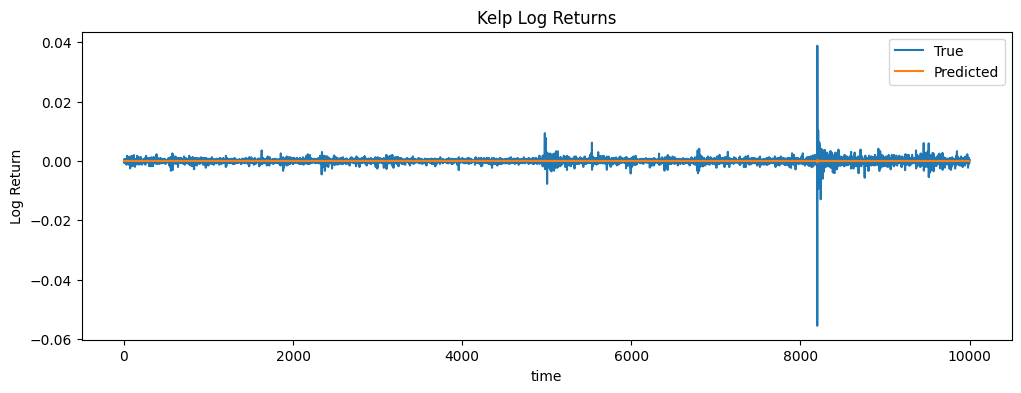

In [153]:
plt.figure(figsize=(12, 4))
plt.plot(valid_logr[1:], label='True')
plt.plot(preds, label='Predicted')
plt.title('Kelp Log Returns')
plt.xlabel('time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

In [154]:
pred_price = valid[1:-1] * np.exp(preds)

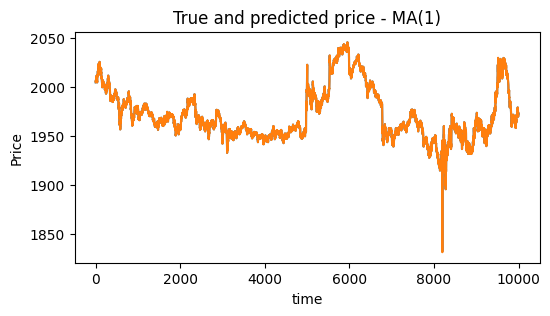

In [156]:
plt.figure(figsize=(6, 3))
plt.plot(valid[2:])
plt.plot(pred_price)
plt.title('True and predicted price - MA(1)')
plt.xlabel('time')
plt.ylabel('Price')
plt.show()

In [157]:
err = valid_logr[1:] - preds
rmse = np.mean(err ** 2) ** 0.5
print(f'Log-returns RMSE: {rmse}')

err = valid[2:] - pred_price
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE: {rmse}')

Log-returns RMSE: 0.0010417339731316347
Price RMSE: 2.009248384812005


### AR(2)

In [158]:
model = AutoReg(train_logr, lags=2)
model_fit = model.fit()

In [159]:
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 9999
Model:                     AutoReg(2)   Log Likelihood               56789.771
Method:               Conditional MLE   S.D. of innovations              0.001
Date:                Tue, 08 Apr 2025   AIC                        -113571.541
Time:                        11:39:11   BIC                        -113542.701
Sample:                             2   HQIC                       -113561.779
                                 9999                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.223e-07   8.26e-06      0.027      0.979    -1.6e-05    1.64e-05
y.L1           0.0076      0.010      0.756      0.450      -0.012       0.027
y.L2           0.0072      0.010      0.723      0.4

In [160]:
model_fit.params

array([2.22332541e-07, 7.55659357e-03, 7.22894604e-03])

In [161]:
preds = valid_logr[:-2] * 0.0072 + valid_logr[1:-1] * 0.0076

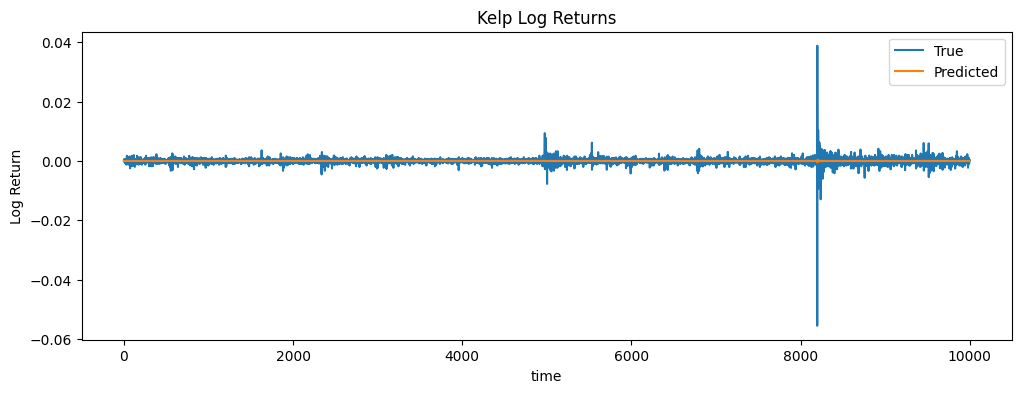

In [162]:
plt.figure(figsize=(12, 4))
plt.plot(valid_logr[2:], label='True')
plt.plot(preds, label='Predicted')
plt.title('Kelp Log Returns')
plt.xlabel('time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

In [163]:
pred_price = valid[2:-1] * np.exp(preds)

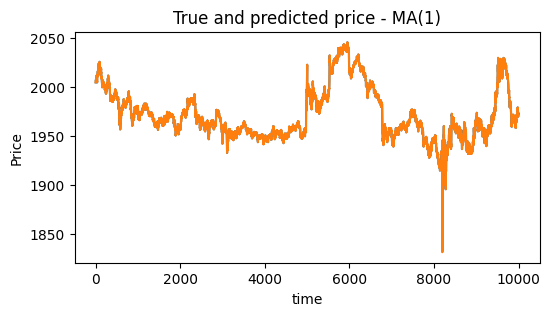

In [165]:
plt.figure(figsize=(6, 3))
plt.plot(valid[3:])
plt.plot(pred_price)
plt.title('True and predicted price - MA(1)')
plt.xlabel('time')
plt.ylabel('Price')
plt.show()

In [166]:
err = valid_logr[2:] - preds
rmse = np.mean(err ** 2) ** 0.5
print(f'Log-returns RMSE: {rmse}')

err = valid[3:] - pred_price
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE: {rmse}')

Log-returns RMSE: 0.0010425525290590734
Price RMSE: 2.0108150867776073


### AR(3)

In [171]:
model = AutoReg(train_logr, lags=3)
model_fit = model.fit()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 9999
Model:                     AutoReg(3)   Log Likelihood               56792.916
Method:               Conditional MLE   S.D. of innovations              0.001
Date:                Tue, 08 Apr 2025   AIC                        -113575.832
Time:                        11:47:38   BIC                        -113539.782
Sample:                             3   HQIC                       -113563.629
                                 9999                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.418e-07   8.25e-06      0.029      0.977   -1.59e-05    1.64e-05
y.L1           0.0072      0.010      0.724      0.469      -0.012       0.027
y.L2           0.0069      0.010      0.690      0.4

In [172]:
model_fit.params

array([2.41758299e-07, 7.23622304e-03, 6.89446459e-03, 4.30723801e-02])

In [173]:
preds = valid_logr[:-3] * 0.0431 + valid_logr[1:-2] * 0.0069 + valid_logr[2:-1] * 0.0072

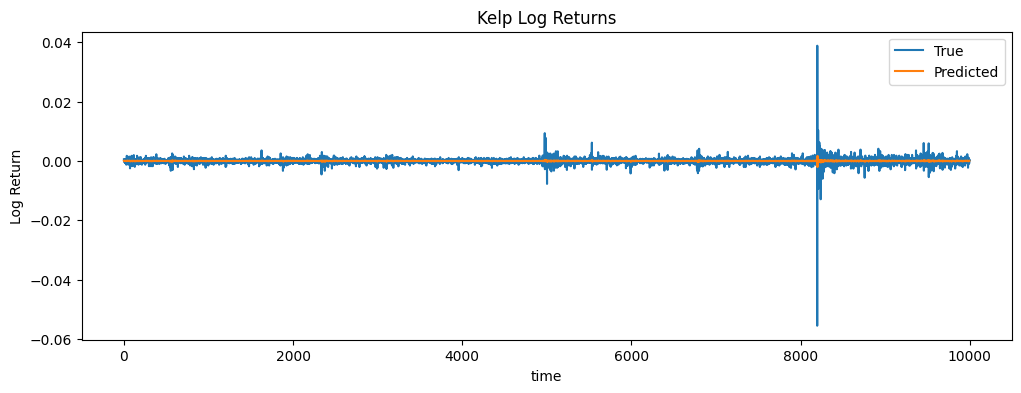

In [174]:
plt.figure(figsize=(12, 4))
plt.plot(valid_logr[3:], label='True')
plt.plot(preds, label='Predicted')
plt.title('Kelp Log Returns')
plt.xlabel('time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

In [175]:
pred_price = valid[3:-1] * np.exp(preds)

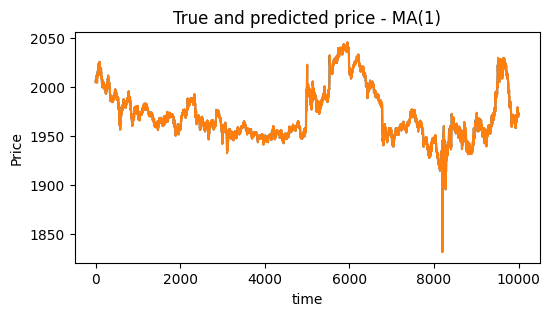

In [176]:
plt.figure(figsize=(6, 3))
plt.plot(valid[4:])
plt.plot(pred_price)
plt.title('True and predicted price - MA(1)')
plt.xlabel('time')
plt.ylabel('Price')
plt.show()

In [178]:
err = valid_logr[3:] - preds
rmse = np.mean(err ** 2) ** 0.5
print(f'Log-returns RMSE: {rmse}')

err = valid[4:] - pred_price
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE: {rmse}')

Log-returns RMSE: 0.00104120354075767
Price RMSE: 2.008287671028907


### AR(4)

In [179]:
model = AutoReg(train_logr, lags=4)
model_fit = model.fit()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 9999
Model:                     AutoReg(4)   Log Likelihood               56787.946
Method:               Conditional MLE   S.D. of innovations              0.001
Date:                Tue, 08 Apr 2025   AIC                        -113563.893
Time:                        11:49:26   BIC                        -113520.634
Sample:                             4   HQIC                       -113549.249
                                 9999                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.663e-07   8.25e-06      0.032      0.974   -1.59e-05    1.64e-05
y.L1           0.0079      0.010      0.789      0.430      -0.012       0.027
y.L2           0.0070      0.010      0.700      0.4

In [180]:
model_fit.params

array([ 2.66336580e-07,  7.88698394e-03,  6.99132014e-03,  4.31744688e-02,
       -1.53069009e-02])

In [181]:
preds = valid_logr[:-4] * -0.0153 + valid_logr[1:-3] * 0.0432 + valid_logr[2:-2] * 0.0070 + valid_logr[3:-1] * 0.0079

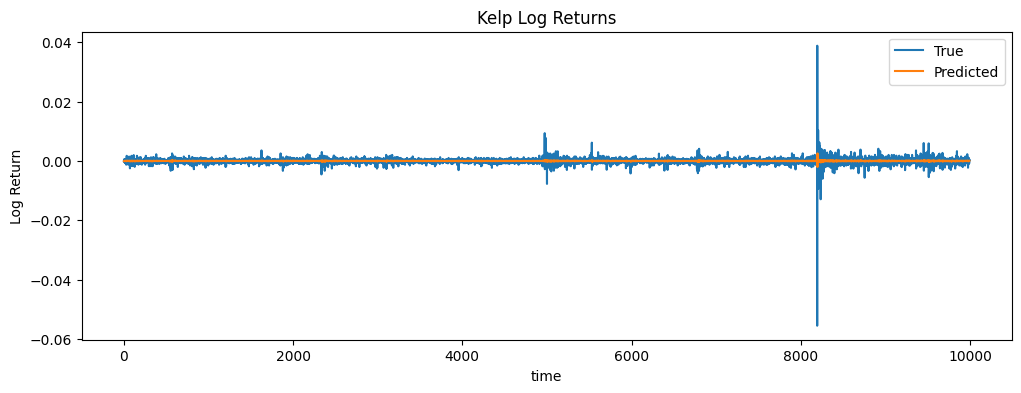

In [182]:
plt.figure(figsize=(12, 4))
plt.plot(valid_logr[4:], label='True')
plt.plot(preds, label='Predicted')
plt.title('Kelp Log Returns')
plt.xlabel('time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

In [183]:
pred_price = valid[4:-1] * np.exp(preds)

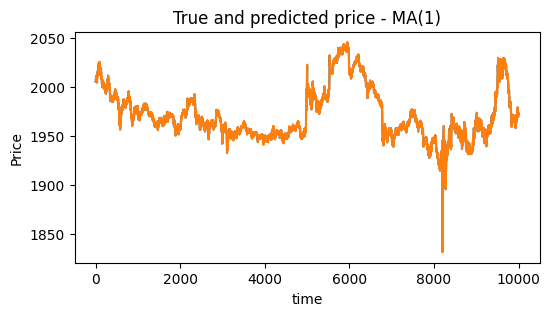

In [184]:
plt.figure(figsize=(6, 3))
plt.plot(valid[5:])
plt.plot(pred_price)
plt.title('True and predicted price - MA(1)')
plt.xlabel('time')
plt.ylabel('Price')
plt.show()

In [186]:
err = valid_logr[4:] - preds
rmse = np.mean(err ** 2) ** 0.5
print(f'Log-returns RMSE: {rmse}')

err = valid[5:] - pred_price
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE: {rmse}')

Log-returns RMSE: 0.0010412513251603802
Price RMSE: 2.0083933817079385
